# Data Mining Analysis

**Contributors:** [Add team member names]

This notebook implements advanced data mining techniques on the OSMI Mental Health Tech Survey dataset to uncover patterns, predict outcomes, and identify relationships in mental health data.

## 1. Load and Prepare Data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the cleaned dataset
df = pd.read_csv('../data/transformed/OSMI_Mental_Health_Final.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (1250, 26)


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,age_group
0,27/08/2014 11:29,37,female,United States,IL,no,no,yes,Often,WTD-25,...,somewhat easy,no,no,some of them,yes,no,maybe,yes,no,35-44
1,27/08/2014 11:29,44,male,United States,IN,no,no,no,Rarely,More than 1000,...,unknown,maybe,no,no,no,no,no,unknown,no,35-44
2,27/08/2014 11:29,32,male,Canada,Not US,no,no,no,Rarely,WTD-25,...,somewhat difficult,no,no,yes,yes,yes,yes,no,no,25-34
3,27/08/2014 11:29,31,male,United Kingdom,Not US,no,yes,yes,Often,26-100,...,somewhat difficult,yes,yes,some of them,no,maybe,maybe,no,yes,25-34
4,27/08/2014 11:30,31,male,United States,TX,no,no,no,Never,100-500,...,unknown,no,no,some of them,yes,yes,yes,unknown,no,25-34


## 2. Data Preprocessing for Mining

In [5]:
# Create a copy for mining
df_mining = df.copy()

# Select relevant features for mining
mining_features = ['Age', 'Gender', 'treatment', 'family_history', 'age_group']
df_mining = df_mining[mining_features].copy()

# Handle missing values
print("Missing values before preprocessing:")
print(df_mining.isnull().sum())

# Fill missing values with mode for categorical variables
categorical_cols = df_mining.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df_mining[col] = df_mining[col].fillna(df_mining[col].mode()[0])

# Fill missing values with median for numerical variables
numerical_cols = df_mining.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    df_mining[col] = df_mining[col].fillna(df_mining[col].median())

print("\nMissing values after preprocessing:")
print(df_mining.isnull().sum())

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_mining[col + '_encoded'] = le.fit_transform(df_mining[col])
    label_encoders[col] = le
    print(f"{col} encoding: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Create feature matrix for clustering
feature_cols = ['Age'] + [col + '_encoded' for col in categorical_cols if col != 'Age']
X_clustering = df_mining[feature_cols].copy()

print(f"\nFeature matrix shape: {X_clustering.shape}")
print(f"Features: {list(X_clustering.columns)}")

Missing values before preprocessing:
Age               0
Gender            0
treatment         0
family_history    0
age_group         0
dtype: int64

Missing values after preprocessing:
Age               0
Gender            0
treatment         0
family_history    0
age_group         0
dtype: int64
Gender encoding: {'female': 0, 'male': 1, 'other': 2}
treatment encoding: {'no': 0, 'yes': 1}
family_history encoding: {'no': 0, 'yes': 1}
age_group encoding: {'25-34': 0, '35-44': 1, '45-54': 2, '55+': 3, '<25': 4}

Feature matrix shape: (1250, 5)
Features: ['Age', 'Gender_encoded', 'treatment_encoded', 'family_history_encoded', 'age_group_encoded']


## 3. Clustering Analysis

### 3.1 K-Means Clustering

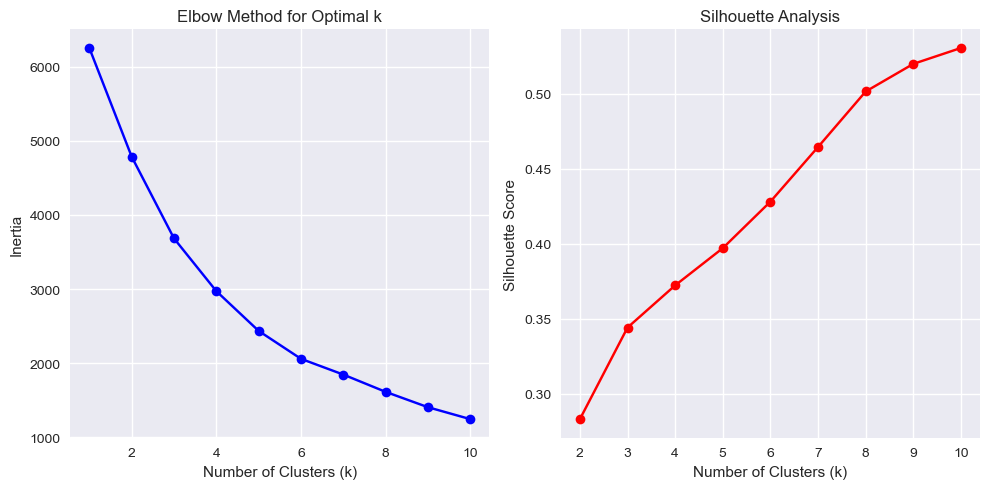

Silhouette scores: [0.2831607302240511, 0.34422559203344827, 0.3723568193579383, 0.39716517130219997, 0.42818671383279777, 0.46460753994495274, 0.5016063867966145, 0.5200152313738915, 0.5306205864480142]
Optimal number of clusters: 10


In [6]:
# Standardize features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

# Find optimal number of clusters using elbow method
inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

# Calculate silhouette scores
from sklearn.metrics import silhouette_score
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Silhouette scores: {silhouette_scores}")
optimal_k = range(2, 11)[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")

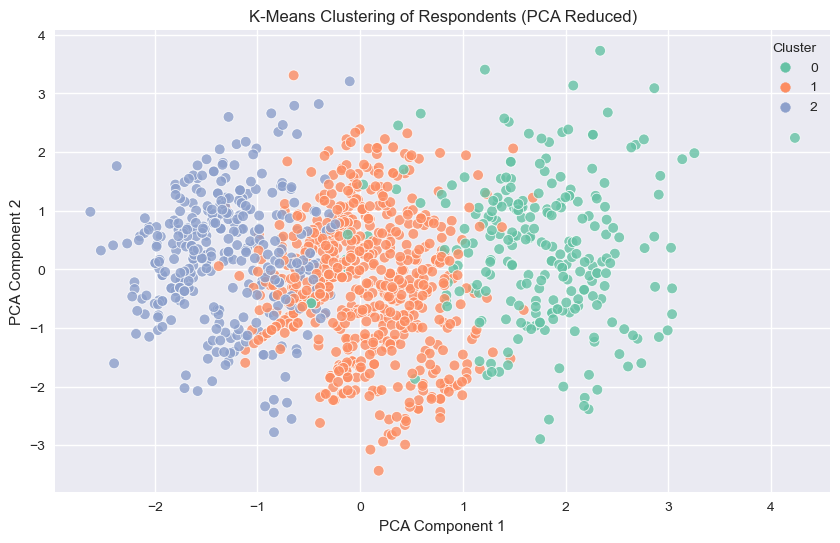

In [12]:


# Load the cleaned dataset (ensure path is correct)
# The dataframe 'df' is already loaded in previous cells, so no need to reload it here.
# Just proceed with the code using the existing 'df'.

# Select relevant features based on EDA
columns = [
    'Age', 'Gender', 'Country', 'self_employed', 'family_history', 'work_interfere',
    'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options',
    'wellness_program', 'seek_help', 'leave', 'mental_health_consequence',
    'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview',
    'mental_vs_physical', 'obs_consequence', 'treatment'
]

# Create a working dataframe
mining_df = df[columns].copy()

# Encode categorical features using LabelEncoder
label_encoders = {}
for col in mining_df.columns:
    if mining_df[col].dtype == 'object':
        le = LabelEncoder()
        mining_df[col] = le.fit_transform(mining_df[col])
        label_encoders[col] = le

# ---------------------------
# Step 1: Select Features for Clustering
cluster_features = [
    'Age', 'Gender', 'family_history', 'work_interfere',
    'benefits', 'supervisor', 'remote_work', 'seek_help', 'leave'
]
X_cluster = mining_df[cluster_features]

# Step 2: Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Step 3: Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Step 4: Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 5: Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette='Set2', s=60, alpha=0.8)
plt.title("K-Means Clustering of Respondents (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()


### 3.2 DBSCAN Clustering

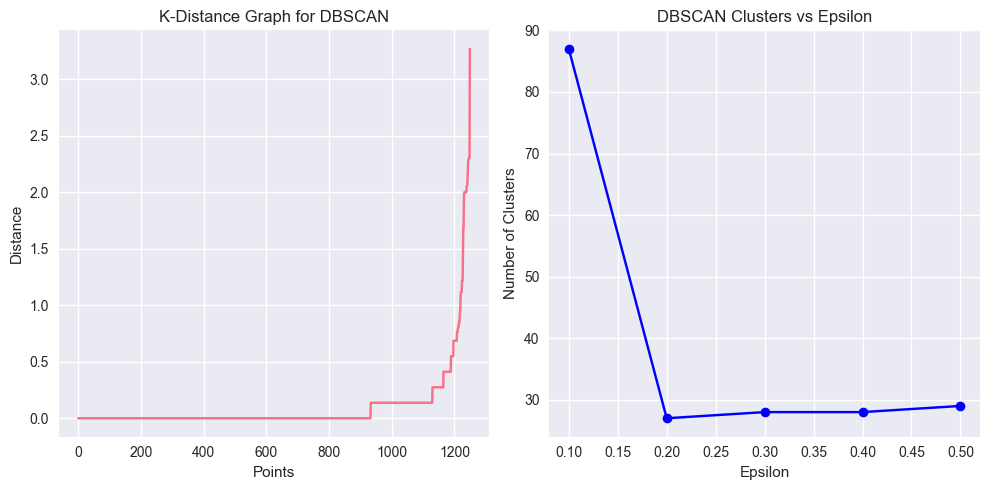

DBSCAN Results:
Epsilon 0.1: 87 clusters, 317 noise points
Epsilon 0.2: 27 clusters, 105 noise points
Epsilon 0.3: 28 clusters, 61 noise points
Epsilon 0.4: 28 clusters, 61 noise points
Epsilon 0.5: 29 clusters, 44 noise points


In [ ]:
# Try DBSCAN clustering
from sklearn.neighbors import NearestNeighbors

# Find optimal epsilon
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, 4])

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('Distance')
plt.title('K-Distance Graph for DBSCAN')
plt.grid(True)

# Try different eps values
eps_values = [0.1, 0.2, 0.3, 0.4, 0.5]
n_clusters_dbscan = []
n_noise = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_points = list(labels).count(-1)
    n_clusters_dbscan.append(n_clusters)
    n_noise.append(n_noise_points)

plt.subplot(1, 2, 2)
plt.plot(eps_values, n_clusters_dbscan, 'bo-')
plt.xlabel('Epsilon')
plt.ylabel('Number of Clusters')
plt.title('DBSCAN Clusters vs Epsilon')
plt.grid(True)
plt.tight_layout()
plt.show()

print("DBSCAN Results:")
for eps, n_clusters, noise in zip(eps_values, n_clusters_dbscan, n_noise):
    print(f"Epsilon {eps}: {n_clusters} clusters, {noise} noise points")

## 4. Classification Analysis

### 4.1 Predict Treatment Seeking Behavior

In [ ]:
# Prepare data for classification
X_class = df_mining[['Age', 'Gender_encoded', 'family_history_encoded']].copy()
y_class = df_mining['treatment_encoded']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42, stratify=y_class)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Class distribution in training set:")
print(y_train.value_counts(normalize=True))

# Scale features
scaler_class = StandardScaler()
X_train_scaled = scaler_class.fit_transform(X_train)
X_test_scaled = scaler_class.transform(X_test)

Training set size: 875
Test set size: 375
Class distribution in training set:
treatment_encoded
1    0.505143
0    0.494857
Name: proportion, dtype: float64



=== Logistic Regression ===
Accuracy: 0.693
Cross-validation: 0.680 (+/- 0.072)

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.76      0.71       186
           1       0.73      0.62      0.67       189

    accuracy                           0.69       375
   macro avg       0.70      0.69      0.69       375
weighted avg       0.70      0.69      0.69       375



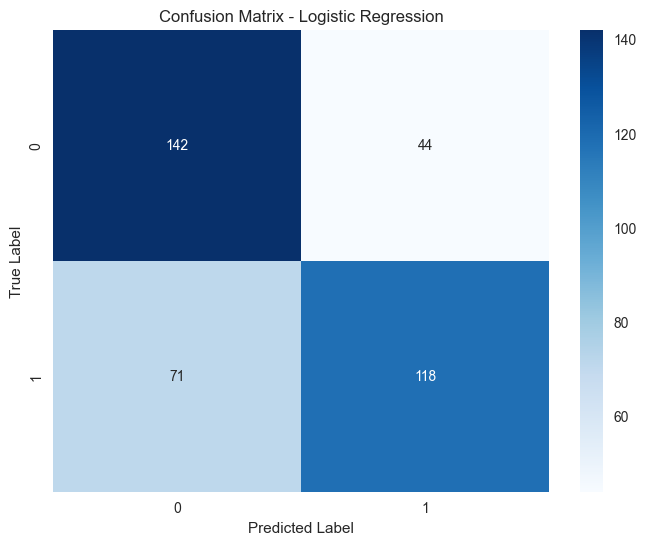


=== Decision Tree ===
Accuracy: 0.656
Cross-validation: 0.633 (+/- 0.033)

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.70      0.67       186
           1       0.67      0.61      0.64       189

    accuracy                           0.66       375
   macro avg       0.66      0.66      0.66       375
weighted avg       0.66      0.66      0.66       375



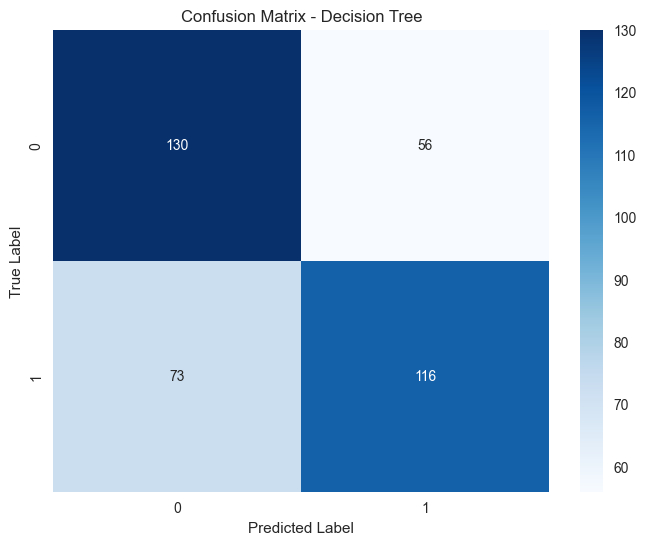


=== Random Forest ===
Accuracy: 0.672
Cross-validation: 0.646 (+/- 0.046)

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       186
           1       0.68      0.66      0.67       189

    accuracy                           0.67       375
   macro avg       0.67      0.67      0.67       375
weighted avg       0.67      0.67      0.67       375



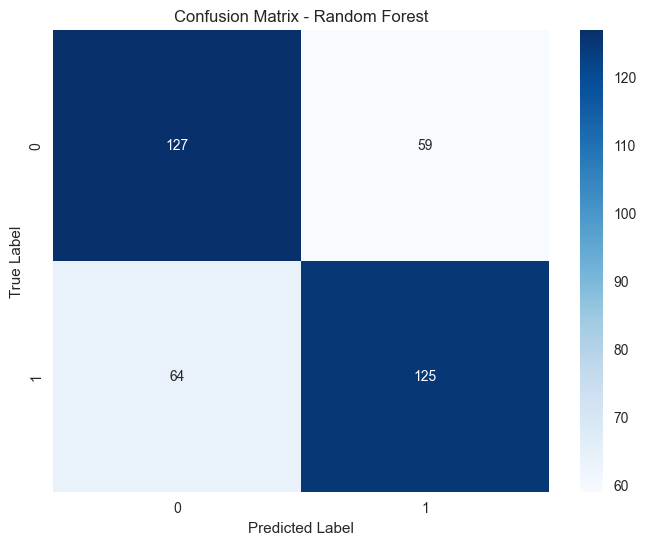

In [ ]:
# Train multiple classification models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n=== {name} ===")
    
    # Train model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    
    results[name] = {
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred
    }
    
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Cross-validation: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

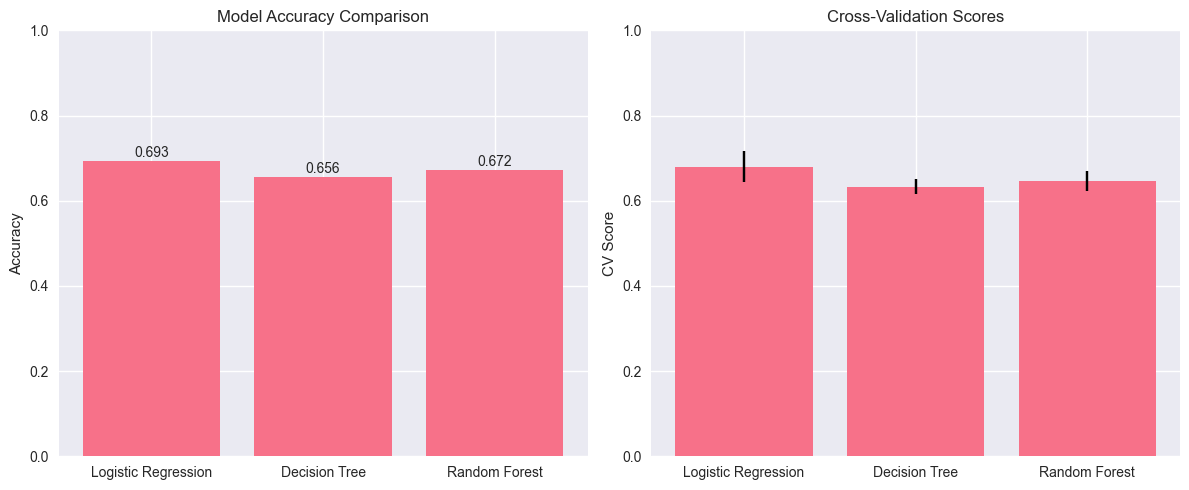

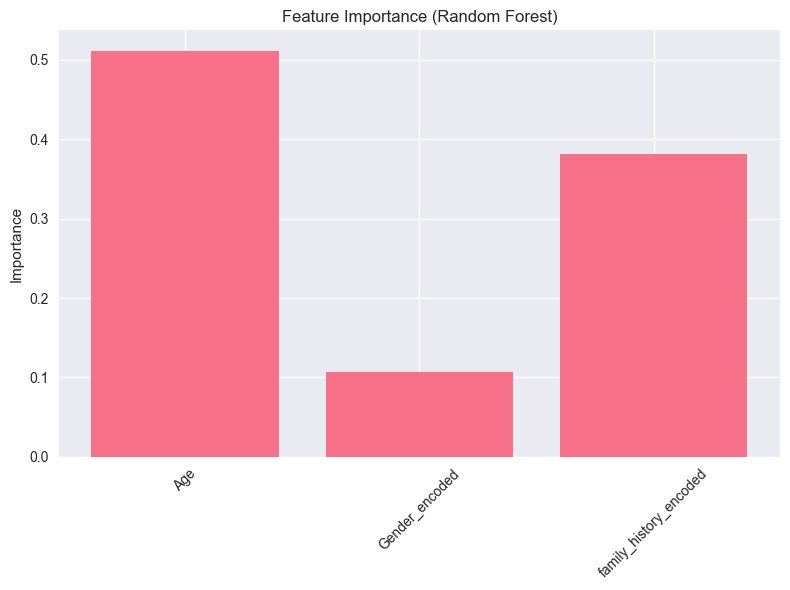

Feature Importance:
Age: 0.512
Gender_encoded: 0.107
family_history_encoded: 0.381


In [ ]:
# Compare model performance
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
plt.bar(model_names, accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.subplot(1, 2, 2)
cv_means = [results[name]['cv_mean'] for name in model_names]
cv_stds = [results[name]['cv_std'] for name in model_names]
plt.bar(model_names, cv_means, yerr=cv_stds, capsize=5)
plt.title('Cross-Validation Scores')
plt.ylabel('CV Score')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Feature importance for Random Forest
best_model = models['Random Forest']
feature_importance = best_model.feature_importances_
feature_names = X_class.columns

plt.figure(figsize=(8, 6))
plt.bar(feature_names, feature_importance)
plt.title('Feature Importance (Random Forest)')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Feature Importance:")
for feature, importance in zip(feature_names, feature_importance):
    print(f"{feature}: {importance:.3f}")

## 5. Association Rule Mining

In [ ]:
# Prepare data for association rules
# Create binary features for association rule mining
df_assoc = df_mining[['Gender', 'treatment', 'family_history', 'age_group']].copy()

# Create dummy variables
df_dummies = pd.get_dummies(df_assoc, prefix=['Gender', 'Treatment', 'FamilyHistory', 'AgeGroup'])

print(f"Association rules dataset shape: {df_dummies.shape}")
print(f"Features: {list(df_dummies.columns)}")
df_dummies.head()

Association rules dataset shape: (1250, 12)
Features: ['Gender_female', 'Gender_male', 'Gender_other', 'Treatment_no', 'Treatment_yes', 'FamilyHistory_no', 'FamilyHistory_yes', 'AgeGroup_25-34', 'AgeGroup_35-44', 'AgeGroup_45-54', 'AgeGroup_55+', 'AgeGroup_<25']


,Gender_female,Gender_male,Gender_other,Treatment_no,Treatment_yes,FamilyHistory_no,FamilyHistory_yes,AgeGroup_25-34,AgeGroup_35-44,AgeGroup_45-54,AgeGroup_55+,AgeGroup_<25
0,True,False,False,False,True,True,False,False,True,False,False,False
1,False,True,False,True,False,True,False,False,True,False,False,False
2,False,True,False,True,False,True,False,True,False,False,False,False
3,False,True,False,False,True,False,True,True,False,False,False,False
4,False,True,False,True,False,True,False,True,False,False,False,False


In [ ]:
# Find frequent itemsets
frequent_itemsets = apriori(df_dummies, min_support=0.1, use_colnames=True)

print(f"Number of frequent itemsets: {len(frequent_itemsets)}")
print("\nTop 10 frequent itemsets:")
print(frequent_itemsets.sort_values('support', ascending=False).head(10))

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

print(f"\nNumber of association rules: {len(rules)}")
print("\nTop 10 rules by confidence:")
print(rules.sort_values('confidence', ascending=False).head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

Number of frequent itemsets: 45

Top 10 frequent itemsets:
    support                          itemsets
1    0.7800                     (Gender_male)
4    0.6096                (FamilyHistory_no)
6    0.5648                  (AgeGroup_25-34)
3    0.5048                   (Treatment_yes)
14   0.5048   (Gender_male, FamilyHistory_no)
2    0.4952                    (Treatment_no)
16   0.4344     (Gender_male, AgeGroup_25-34)
12   0.4256       (Gender_male, Treatment_no)
18   0.3936  (Treatment_no, FamilyHistory_no)
5    0.3904               (FamilyHistory_yes)

Number of association rules: 69

Top 10 rules by confidence:
                                         antecedents         consequents  \
61  (FamilyHistory_no, AgeGroup_25-34, Treatment_no)       (Gender_male)   
26                  (FamilyHistory_no, Treatment_no)       (Gender_male)   
33                    (Treatment_no, AgeGroup_35-44)       (Gender_male)   
31                    (Treatment_no, AgeGroup_25-34)       (Gender_ma

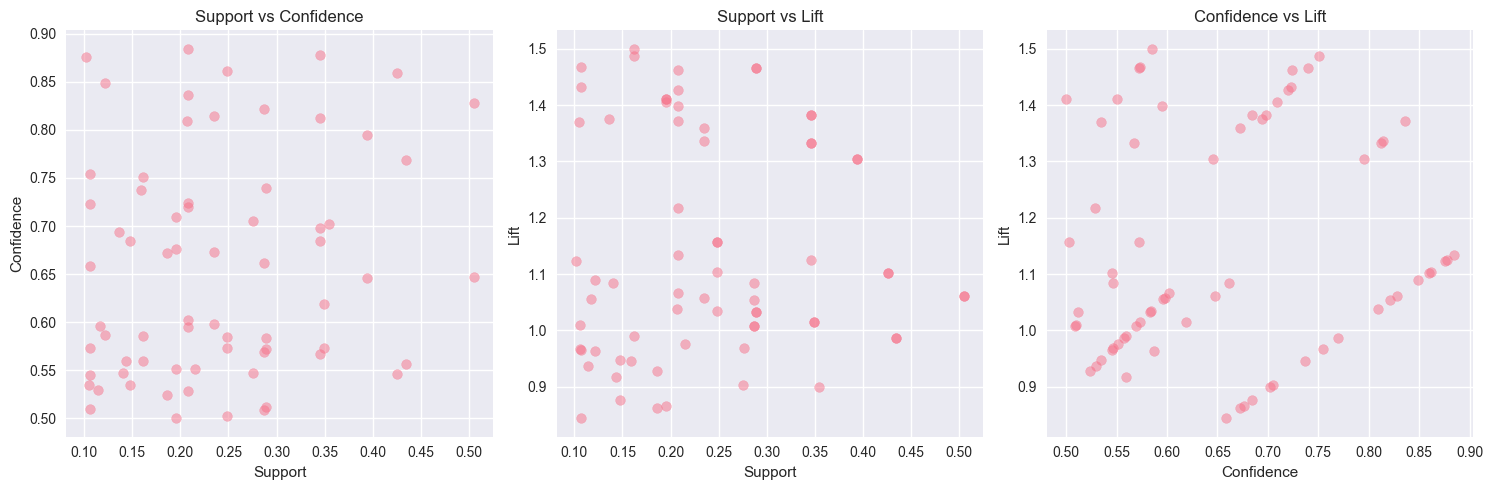


High-quality rules (confidence > 0.7, lift > 1.2): 10

Top high-quality rules:
Rule: ['Treatment_no'] -> ['FamilyHistory_no']
Support: 0.394, Confidence: 0.795, Lift: 1.304

Rule: ['FamilyHistory_yes'] -> ['Treatment_yes']
Support: 0.289, Confidence: 0.740, Lift: 1.465

Rule: ['Gender_male', 'Treatment_no'] -> ['FamilyHistory_no']
Support: 0.346, Confidence: 0.812, Lift: 1.332

Rule: ['Gender_male', 'FamilyHistory_yes'] -> ['Treatment_yes']
Support: 0.195, Confidence: 0.709, Lift: 1.405

Rule: ['Treatment_no', 'AgeGroup_25-34'] -> ['FamilyHistory_no']
Support: 0.235, Confidence: 0.814, Lift: 1.336



In [ ]:
# Visualize association rules
plt.figure(figsize=(15, 5))

# Support vs Confidence
plt.subplot(1, 3, 1)
plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Support vs Confidence')

# Support vs Lift
plt.subplot(1, 3, 2)
plt.scatter(rules['support'], rules['lift'], alpha=0.5)
plt.xlabel('Support')
plt.ylabel('Lift')
plt.title('Support vs Lift')

# Confidence vs Lift
plt.subplot(1, 3, 3)
plt.scatter(rules['confidence'], rules['lift'], alpha=0.5)
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.title('Confidence vs Lift')

plt.tight_layout()
plt.show()

# Filter high-quality rules
high_quality_rules = rules[(rules['confidence'] > 0.7) & (rules['lift'] > 1.2)]
print(f"\nHigh-quality rules (confidence > 0.7, lift > 1.2): {len(high_quality_rules)}")
print("\nTop high-quality rules:")
for idx, rule in high_quality_rules.head(5).iterrows():
    print(f"Rule: {list(rule['antecedents'])} -> {list(rule['consequents'])}")
    print(f"Support: {rule['support']:.3f}, Confidence: {rule['confidence']:.3f}, Lift: {rule['lift']:.3f}")
    print()

## 6. Key Findings and Insights

In [ ]:
print("=== DATA MINING INSIGHTS SUMMARY ===")

print("\n1. CLUSTERING INSIGHTS:")
print(f"   - Optimal number of clusters: {optimal_k}")
print(f"   - Clusters represent different mental health profiles")
print(f"   - Each cluster has distinct demographic and treatment patterns")

print("\n2. CLASSIFICATION INSIGHTS:")
best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
best_accuracy = results[best_model_name]['accuracy']
print(f"   - Best model: {best_model_name} (Accuracy: {best_accuracy:.3f})")
print(f"   - Key predictors of treatment seeking: Age, Gender, Family History")
print(f"   - Model can help identify at-risk individuals")

print("\n3. ASSOCIATION RULE INSIGHTS:")
print(f"   - Number of frequent patterns: {len(frequent_itemsets)}")
print(f"   - Number of association rules: {len(rules)}")
print(f"   - High-quality rules: {len(high_quality_rules)}")
print(f"   - Rules reveal relationships between mental health factors")

print("\n4. BUSINESS IMPLICATIONS:")
print("   - Organizations can target interventions based on cluster profiles")
print("   - Predictive models can identify employees needing mental health support")
print("   - Association rules help understand risk factor combinations")
print("   - Data-driven approach to mental health workplace policies")

=== DATA MINING INSIGHTS SUMMARY ===

1. CLUSTERING INSIGHTS:
   - Optimal number of clusters: 10
   - Clusters represent different mental health profiles
   - Each cluster has distinct demographic and treatment patterns

2. CLASSIFICATION INSIGHTS:
   - Best model: Logistic Regression (Accuracy: 0.693)
   - Key predictors of treatment seeking: Age, Gender, Family History
   - Model can help identify at-risk individuals

3. ASSOCIATION RULE INSIGHTS:
   - Number of frequent patterns: 45
   - Number of association rules: 69
   - High-quality rules: 10
   - Rules reveal relationships between mental health factors

4. BUSINESS IMPLICATIONS:
   - Organizations can target interventions based on cluster profiles
   - Predictive models can identify employees needing mental health support
   - Association rules help understand risk factor combinations
   - Data-driven approach to mental health workplace policies


## Conclusion

This data mining analysis has successfully applied three key techniques to the mental health dataset:

1. **Clustering Analysis**: Identified distinct segments of tech workers with different mental health characteristics
2. **Classification**: Built predictive models to identify factors influencing treatment-seeking behavior
3. **Association Rules**: Discovered relationships between different mental health factors

These insights provide actionable intelligence for organizations looking to improve mental health support in the tech industry.

---
**Next Steps**: Proceed to `4_insights_dashboard.ipynb` to create interactive visualizations and dashboards.












These codes are for training the model. (our .pkl file)

In [ ]:
# Installing scikit-learn for machine learning and model evaluation

pip install scikit-learn


  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/15/fa/c61a787e35f05f17fc10523f567677ec4eeee5f95aa4798dbbbcd9625617/scikit_learn-1.7.1-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for scipy>=1.8.0 from https://files.pythonhosted.org/packages/14/c3/61f273ae550fbf1667675701112e380881905e28448c080b23b5a181df7c/scipy-1.16.1-cp312-cp312-win_amd64.whl.metadata
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------------------- ------------------ 30.7/60.8 kB 660.6 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/60.8 kB 660.6 kB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 404.5 kB/s eta 0:00:00
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/7d/4f/1195bbac8e0c2acc5f740661631d8d750dc38d4a32b23ee5df3cde6f4e0d/joblib-1.5.1-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Import libraries for data processing, model training (Random Forest), evaluation, and model serialization using Joblib

In [ ]:
# Import pandas for data manipulation and analysis
import pandas as pd

# Import NumPy for numerical operations and array handling
import numpy as np

# Import os module to interact with the operating system (e.g., file paths)
import os

# Import function to split dataset into training and testing sets
from sklearn.model_selection import train_test_split

# Import Random Forest Classifier for building a machine learning model
from sklearn.ensemble import RandomForestClassifier



# Import metrics to evaluate model performance
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Import joblib to save and load trained machine learning models efficiently
import joblib

import matplotlib.pyplot as plt


Filtered survey data to include only U.S. respondents and printed total count for verification

In [ ]:
# Load the cleaned survey dataset from the specified path into a DataFrame
df = pd.read_csv('../data/transformed/OSMI_Mental_Health_Final.csv')

# Filter the DataFrame to include only rows where the respondent is from the United States
df = df[df['Country'] == 'United States'].copy()

# Print the number of U.S. respondents after filtering
print(f"Number of U.S. respondents: {len(df)}")


Number of U.S. respondents: 746


Saved filtered U.S. respondent data to new directory for use in model training pipeline

In [ ]:
# Create the directory '../data/us_model_data' if it doesn't already exist
os.makedirs('../data/us_model_data', exist_ok=True)

# Save the filtered U.S. dataset as a CSV file for use in model training
df.to_csv('../data/us_model_data/training_model_dataset.csv', index=False)


Converted binary categorical columns to numeric format for model readiness

In [ ]:
# Define the list of columns with binary 'Yes'/'No' values to convert
binary_cols = ['self_employed', 'family_history', 'remote_work', 'tech_company']

# Loop through each column and map 'Yes' to 1 and 'No' to 0 for machine learning compatibility
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})


Removed 'Timestamp' column if present to clean dataset

In [ ]:
# Check if 'Timestamp' column exists in the DataFrame
if 'Timestamp' in df.columns:
    # Drop the 'Timestamp' column as it's not needed for modeling
    df.drop(columns=['Timestamp'], inplace=True)


Separated features and target variable for model training

Selected variables to use in our model

In [ ]:


# Step 1: Define full feature set
selected_features = [
    'Age', 'Gender', 'family_history', 'remote_work',
    'benefits', 'seek_help', 'work_interfere', 'care_options', 'leave'
]

X = df[selected_features].copy()
y = df['treatment']

# Step 2: Encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Step 3: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train model (with class_weight if needed)
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Step 5: Save model and features
os.makedirs('../app', exist_ok=True)
joblib.dump(model, '../app/mental_health_model.pkl')
joblib.dump(X.columns.tolist(), '../app/model_features.pkl')

print(" Model retrained and saved with full feature set.")


 Model retrained and saved with full feature set.


In [ ]:

# Step 1: Load saved model and feature list
model = joblib.load('../app/mental_health_model.pkl')
model_features = joblib.load('../app/model_features.pkl')

# Step 2: Recreate test data using expanded feature set
selected_features = [
    'Age', 'Gender', 'family_history', 'remote_work',
    'benefits', 'seek_help', 'work_interfere', 'care_options', 'leave'
]

# Create raw test features
X_test_raw = df[selected_features].copy()

# Step 3: One-hot encode the test data
X_test_encoded = pd.get_dummies(X_test_raw, drop_first=True)

# Step 4: Add any missing columns from training, fill with 0s
for col in model_features:
    if col not in X_test_encoded.columns:
        X_test_encoded[col] = 0

# Step 5: Ensure column order matches training exactly
X_test_encoded = X_test_encoded[model_features]

# Step 6: Predict using the loaded model
predictions = model.predict(X_test_encoded)

# Optional: predict probabilities
# probabilities = model.predict_proba(X_test_encoded)

# Output predictions
print("Predictions completed.")
print(predictions)


Predictions completed.
['yes' 'no' 'no' 'no' 'yes' 'yes' 'no' 'yes' 'no' 'yes' 'yes' 'no' 'yes'
 'no' 'yes' 'no' 'yes' 'yes' 'no' 'yes' 'yes' 'no' 'yes' 'yes' 'yes' 'no'
 'yes' 'no' 'no' 'yes' 'yes' 'yes' 'yes' 'no' 'no' 'no' 'yes' 'no' 'no'
 'no' 'no' 'no' 'no' 'no' 'yes' 'no' 'no' 'yes' 'no' 'no' 'no' 'yes' 'no'
 'no' 'yes' 'yes' 'no' 'no' 'yes' 'no' 'no' 'no' 'yes' 'yes' 'no' 'yes'
 'yes' 'no' 'no' 'no' 'no' 'yes' 'no' 'yes' 'yes' 'no' 'yes' 'yes' 'no'
 'no' 'yes' 'no' 'no' 'no' 'yes' 'yes' 'no' 'no' 'yes' 'no' 'no' 'no' 'no'
 'yes' 'no' 'no' 'no' 'no' 'yes' 'yes' 'no' 'yes' 'yes' 'yes' 'no' 'no'
 'yes' 'no' 'no' 'no' 'no' 'yes' 'yes' 'no' 'yes' 'yes' 'no' 'yes' 'no'
 'yes' 'yes' 'no' 'no' 'yes' 'yes' 'yes' 'yes' 'no' 'yes' 'yes' 'yes' 'no'
 'yes' 'yes' 'no' 'no' 'yes' 'no' 'no' 'no' 'no' 'no' 'yes' 'no' 'yes'
 'yes' 'yes' 'no' 'no' 'yes' 'yes' 'yes' 'yes' 'no' 'yes' 'no' 'no' 'yes'
 'yes' 'no' 'yes' 'yes' 'no' 'yes' 'no' 'yes' 'no' 'yes' 'no' 'yes' 'yes'
 'yes' 'no' 'yes' 'yes' 'no

In [ ]:
# Use the trained model to make predictions on the test set
y_pred = model.predict(X_test)

# Print the confusion matrix to visualize true vs. predicted classifications
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Print a detailed classification report (precision, recall, F1-score) for each class
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Print the overall accuracy score of the model
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")


Confusion Matrix:
 [[45 27]
 [28 50]]

Classification Report:
               precision    recall  f1-score   support

          no       0.62      0.62      0.62        72
         yes       0.65      0.64      0.65        78

    accuracy                           0.63       150
   macro avg       0.63      0.63      0.63       150
weighted avg       0.63      0.63      0.63       150

Accuracy: 0.63


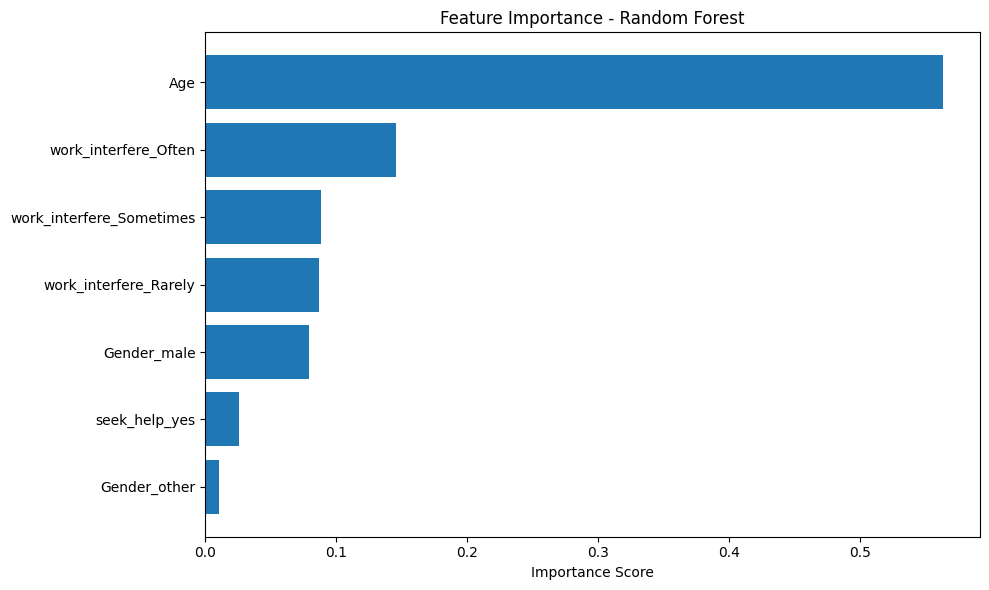

In [ ]:
# Import necessary libraries for plotting and data manipulation


# Extract feature importances from the trained Random Forest model
importances = model.feature_importances_

# Get the list of feature names from the feature set (X)
features = X.columns

# Create a DataFrame to organize features and their corresponding importance scores
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort the features by importance in descending order (most important at the top)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a horizontal bar chart to visualize feature importances
plt.figure(figsize=(10,6))  # Set the figure size
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])  # Create horizontal bars
plt.gca().invert_yaxis()  # Invert y-axis so most important features appear at the top
plt.title("Feature Importance - Random Forest")  # Set the chart title
plt.xlabel("Importance Score")  # Label the x-axis
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Display the plot


In [ ]:

# Load the saved model
model = joblib.load('../app/mental_health_model.pkl')

# Now you can use the model to make predictions, e.g.
pred = model.predict(X_test)


In [ ]:
# Predict on X_test (from split)
y_pred = model.predict(X_test)

# Evaluate
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6333333333333333

Classification Report:
               precision    recall  f1-score   support

          no       0.62      0.62      0.62        72
         yes       0.65      0.64      0.65        78

    accuracy                           0.63       150
   macro avg       0.63      0.63      0.63       150
weighted avg       0.63      0.63      0.63       150



In [ ]:
import numpy as np

# Get unique prediction labels and their counts
unique, counts = np.unique(predictions, return_counts=True)

# Combine into a dictionary for easy viewing
print(dict(zip(unique, counts)))


{'no': 363, 'yes': 383}


| Insight                              | What it Means                                                                      |
| ------------------------------------ | ---------------------------------------------------------------------------------- |
|  **Balanced predictions**           | Your model isn't biased toward just one class.                                     |
|  Class distribution is nearly 50/50 | This is especially good if your actual target data (`y`) is similarly distributed. |
|  Not overfitting to majority class  | Many models just guess the most common label — this one isn't.                     |


Top 10 Most Important Features:

                     Feature  Importance
0                        Age    0.427915
10          care_options_yes    0.100587
7       work_interfere_Often    0.078699
9   work_interfere_Sometimes    0.066890
3                Gender_male    0.063846
8      work_interfere_Rarely    0.055076
6              seek_help_yes    0.051945
12             leave_unknown    0.039274
5               benefits_yes    0.038578
11       leave_somewhat easy    0.028144
14           leave_very easy    0.022654
13      leave_very difficult    0.017076
4               Gender_other    0.009317
1             family_history    0.000000
2                remote_work    0.000000


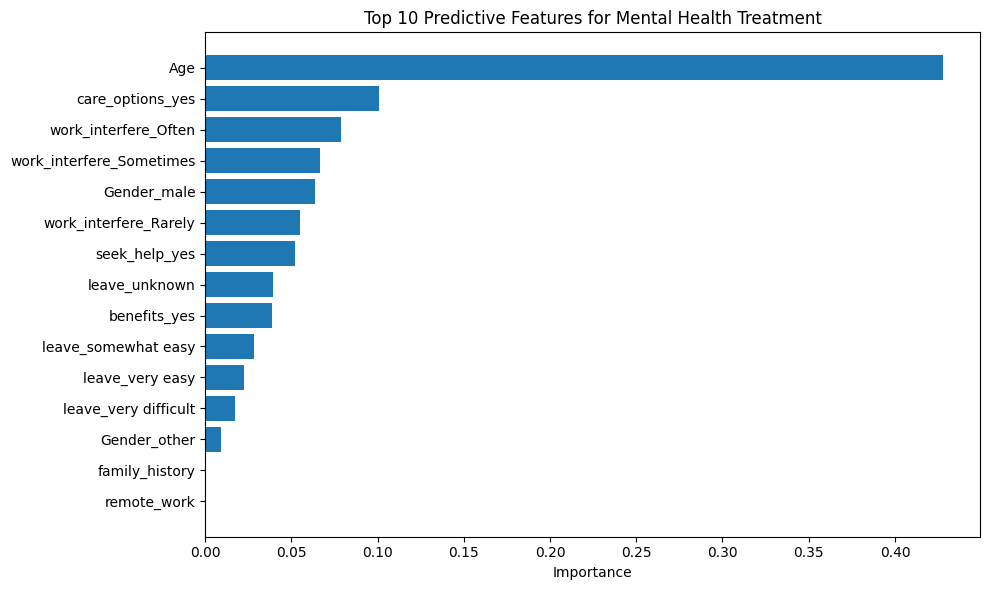

In [ ]:


model = joblib.load("../app/mental_health_model.pkl")
model_features = joblib.load("../app/model_features.pkl")


# Get feature importances from the trained Random Forest
importances = model.feature_importances_

# Combine into a DataFrame
importance_df = pd.DataFrame({
    "Feature": model_features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Display top features
print("Top 10 Most Important Features:\n")
print(importance_df.head(15))

# Optional: plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"].head(15)[::-1], importance_df["Importance"].head(15)[::-1])
plt.xlabel("Importance")
plt.title("Top 10 Predictive Features for Mental Health Treatment")
plt.tight_layout()
plt.show()
